# BERT SHAP

In [ ]:
! pip install pandas==1.2.3
! pip install numpy==1.20.2
! pip install jupyterlab==3.0.12
! pip install matplotlib==3.4.1
! pip install seaborn==0.11.1
! pip install lime==0.2.0.1
! pip install shap==0.39.0
! pip install torch==1.7.1
! pip install datasets==1.5.0
! pip install transformers==4.3.3
! pip install ipywidgets==7.6.3
! pip install tqdm==4.49.0
! pip install checklist==0.0.10
! pip install allennlp==2.1.0
! pip install allennlp-models==2.1.0
! pip install typing==3.7.4.3
! pip install pytreebank==0.2.7
! pip install spacy==3.0.5

In [34]:
import os
import sys
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import shap
from scipy.stats import spearmanr

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.chdir('drive/My Drive/Colab Notebooks/Github/ucl-nlp-group-project')

In [4]:
# project_root_dir = os.path.relpath(os.path.join('..', '..'), os.curdir)
# if project_root_dir not in sys.path:
#     sys.path += [project_root_dir]

In [ ]:
! python -m spacy download en_core_web_sm

In [6]:
from src.data.dataload import \
    load_sst, \
    load_agnews
from src.data.perturbations import \
    remove_commas, \
    remove_all_punctuation, \
    switch_gender, \
    strip_trailing_punct, \
    add_typo, \
    change_first_name, \
    change_last_name, \
    change_location, \
    contraction, \
    swap_adjectives, \
    add_perturbations
from src.models.bertmodel import BertModel
from src.explainers.explainers import SHAPExplainer

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Load datasets

In [8]:
sst = load_sst()
agnews = load_agnews()

input_data = {
    'sst': sst, 
    'agnews': agnews
}

train = {}
dev = {}
test = {}

for dataset in input_data.keys():
    train[dataset], dev[dataset], test[dataset] = input_data[dataset].train_val_test

Using custom data configuration default
Reusing dataset ag_news (/root/.cache/huggingface/datasets/ag_news/default/0.0.0/17ec33e23df9e89565131f989e0fdf78b0cc4672337b582da83fc3c9f79fe34d)


In [9]:
train['sst'].head()

,sentence,label
0,The Rock is destined to be the 21st Century 's...,3
1,The gorgeously elaborate continuation of `` Th...,4
2,Singer/composer Bryan Adams contributes a slew...,3
3,You 'd think by now America would have had eno...,2
4,Yet the act is still charming here .,3


In [10]:
print(train['sst'].shape, dev['sst'].shape, test['sst'].shape)

(8544, 2) (1101, 2) (2210, 2)


In [11]:
train['agnews'].head()

,sentence,label,title
0,"Reuters - Short-sellers, Wall Street's dwindli...",2,Wall St. Bears Claw Back Into the Black (Reuters)
1,Reuters - Private investment firm Carlyle Grou...,2,Carlyle Looks Toward Commercial Aerospace (Reu...
2,Reuters - Soaring crude prices plus worriesabo...,2,Oil and Economy Cloud Stocks' Outlook (Reuters)
3,Reuters - Authorities have halted oil exportfl...,2,Iraq Halts Oil Exports from Main Southern Pipe...
4,"AFP - Tearaway world oil prices, toppling reco...",2,"Oil prices soar to all-time record, posing new..."


In [12]:
print(train['agnews'].shape, dev['agnews'].shape, test['agnews'].shape)

(108000, 3) (12000, 3) (7600, 3)


## Load models

SST

In [13]:
bert_sst = BertModel(device=device)
bert_sst.load_model(sst)

In [14]:
print(f'Individual prediction for {sst.NAME}')
bert_sst.predict(test['sst'].sentence[0])

Individual prediction for sst


,logits,class_probabilities,label
0,-0.986764,0.040054,2
1,1.235412,0.369594,2
2,1.532937,0.497667,2
3,-0.238388,0.084657,2
4,-2.594063,0.008028,2


In [15]:
print(f'Batch prediction for {sst.NAME}')
bert_sst.predict_batch_df(test['sst'].head(100), input_col=sst.SENTENCE)

Batch prediction for sst


,logits,class_probabilities,label
0,"[-0.986763596534729, 1.2354124784469604, 1.532...","[0.04005406051874161, 0.3695943355560303, 0.49...",2
1,"[-1.7541742324829102, -0.8248226642608643, 0.3...","[0.02760814130306244, 0.06992775201797485, 0.2...",3
2,"[-2.8735032081604004, -1.982176661491394, -0.0...","[0.0026741919573396444, 0.006520647555589676, ...",3
3,"[-2.72558331489563, -1.7797043323516846, 0.189...","[0.00502944178879261, 0.012951194308698177, 0....",3
4,"[-2.492720365524292, -2.249992847442627, -0.62...","[0.0027276272885501385, 0.003476965008303523, ...",4
...,...,...,...
95,"[-2.124051809310913, -0.6128088235855103, 0.46...","[0.019058115780353546, 0.08637826889753342, 0....",3
96,"[-0.28996706008911133, 1.4170410633087158, 1.3...","[0.0792505294084549, 0.4368641674518585, 0.426...",1
97,"[-2.7277023792266846, -2.3031375408172607, -0....","[0.002590600633993745, 0.003960836213082075, 0...",3
98,"[-2.707550048828125, -1.587195634841919, 0.298...","[0.004645983222872019, 0.014244308695197105, 0...",3


AG News

In [16]:
bert_agnews = BertModel(device=device)
bert_agnews.load_model(agnews)

In [17]:
print(f'Individual prediction for {agnews.NAME}')
bert_agnews.predict(test['agnews'].sentence[0])

Individual prediction for agnews


,logits,class_probabilities,label
0,0.042553,0.022081,2
1,-3.648040,0.000551,2
2,3.826154,0.971000,2
3,-1.200886,0.006368,2


In [18]:
print(f'Batch prediction for {agnews.NAME}')
bert_agnews.predict_batch_df(test['agnews'].head(10), input_col=agnews.SENTENCE)

Batch prediction for agnews


,logits,class_probabilities,label
0,"[0.042553484439849854, -3.648040771484375, 3.8...","[0.022081194445490837, 0.0005510841147042811, ...",2
1,"[-0.7225910425186157, -2.5803427696228027, -2....","[0.0016198537778109312, 0.00025273457868024707...",3
2,"[-0.43245750665664673, -2.978013515472412, -1....","[0.004643826279789209, 0.00036421261029317975,...",3
3,"[0.26466435194015503, 3.3352932929992676, -3.2...","[0.04081204906105995, 0.8797222375869751, 0.00...",1
4,"[0.4155667722225189, -2.320910692214966, -2.19...","[0.02233503758907318, 0.0014472699258476496, 0...",3
5,"[-2.881136417388916, -2.5347037315368652, -0.9...","[0.00017455800843890756, 0.0002468277234584093...",3
6,"[-2.380444049835205, -2.653226137161255, -1.46...","[0.00021428102627396584, 0.0001631233899388462...",3
7,"[-2.6934218406677246, -2.1670777797698975, -1....","[0.0001593946071807295, 0.0002698125026654452,...",3
8,"[-0.12801243364810944, -3.1953516006469727, -1...","[0.011645970866084099, 0.0005420599482022226, ...",3
9,"[-0.38943910598754883, -4.089916229248047, 0.8...","[0.022109825164079666, 0.0005463719717226923, ...",3


In [19]:
test['agnews'].sentence[0]

"Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."

In [20]:
bert_agnews.predict_proba(test['agnews'].sentence[0])

0    0.022081
1    0.000551
2    0.971000
3    0.006368
Name: class_probabilities, dtype: float64

## SHAP for SST

In [21]:
dev['sst'].head()

,sentence,label
0,It 's a lovely film with lovely performances b...,3
1,"No one goes unindicted here , which is probabl...",2
2,And if you 're not nearly moved to tears by a ...,3
3,"A warm , funny , engaging film .",4
4,Uses sharp humor and insight into human nature...,4


In [23]:
PERTURBATION_REDUCTION = ['strip_punct', 'remove_commas', 'remove_all_punct']
PERTURBATION_LIST = PERTURBATION_REDUCTION + [
    'contraction','change_first_name','change_last_name', 'change_location', 'add_typo', 'switch_gender'  # , 'swap_adj'
]

PERT_STRING_TO_FUNCTION = {
    'strip_punct': strip_trailing_punct, 
    'remove_commas': remove_commas, 
    'remove_all_punct': remove_all_punctuation, 
    'contraction': contraction,
    'change_first_name': change_first_name,
    'change_last_name': change_last_name, 
    'change_location': change_location, 
    'add_typo': add_typo, 
    'switch_gender': switch_gender, 
    'swap_adj': swap_adjectives
}

In [24]:
def bert_detokenize(token_list):
    """
    Reverse BERT tokenization accounting for ##s representing subwords. Based on https://github.com/huggingface/transformers/issues/36
    """
    text = ' '.join(token_list)
    text = text.replace(' ##', '')
    text = text.replace("` `", "``")
    text = text.replace("' '", "''")
    return text

In [25]:
shap_explainer = SHAPExplainer(bert_sst)

In [26]:
%%time
IMPORTANT_WORD_CUTOFF = 5
"""
Top-x words considered most important based on SHAP value. If perturbation affects any of these tokens the example is not considered for evaluation
"""

perturbation_df_dict = {}


for perturbation in PERTURBATION_LIST:
    
    print(perturbation)
    
    #===============================================#
    # Add perturbed sentences to dataframe          #
    #===============================================#
    
    perturbation_df = add_perturbations(
        df=dev['sst'],
        tokenizer=bert_sst.tokenizer,
        sentence_col_name=sst.SENTENCE, 
        perturbation_functions=[
            PERT_STRING_TO_FUNCTION[perturbation]
        ]
    )
    print(1)
    print(perturbation_df.shape)
    
    #===============================================#
    # Drop unsuccessful perturbations               #
    #===============================================#
    
    perturbation_df = perturbation_df.copy()[perturbation_df[f'{perturbation}_success'] == 1]
    print(2)
    print(perturbation_df.shape)
    if perturbation_df.shape[0] <= 2:
        print(f'Skipped {perturbation}')
        print('\n')
        perturbation_df_dict[perturbation] = None
        continue
    
    #====================================================================#
    # Overwrite '_concat' column with corrected reversal of tokenization #
    #====================================================================#
    
    perturbation_df[f'{perturbation}_concat'] = perturbation_df[f'{perturbation}_tokens'].apply(bert_detokenize)
    
    #===============================================#
    # Original prediction                           #
    #===============================================#
    
    perturbation_df['orig_prediction'] = bert_sst.predict_label_batch(perturbation_df['sentence'])
    
    #===============================================#
    # Prediction on new sentence                    #
    #===============================================#
    
    perturbation_df[f'{perturbation}_prediction'] = bert_sst.predict_label_batch(perturbation_df[f'{perturbation}_concat'])
    
    #========================================================#
    # Drop examples where predictions which are not the same #
    #========================================================#
    
    perturbation_df = perturbation_df.copy()[perturbation_df[f'{perturbation}_prediction'] == perturbation_df['orig_prediction']]
    print(3)
    print(perturbation_df.shape)
    if perturbation_df.shape[0] <= 2:
        print(f'Skipped {perturbation}')
        print('\n')
        perturbation_df_dict[perturbation] = None
        continue
    
    #===============================================#
    # Flag for correct prediction                   #
    #===============================================#

    perturbation_df['correct_prediction'] = np.where(
        perturbation_df['label'] == perturbation_df['orig_prediction'],
        1,
        0
    )
    print(4)
    print(perturbation_df['correct_prediction'].sum())
    
    #===============================================#
    # SHAP values for original sentence             #
    #===============================================#
    
    shap_values = shap_explainer.explain_instances(perturbation_df['sentence'])
    
    perturbation_df['shap_orig_tokens'] = shap_values.data
    perturbation_df['shap_orig_tokens'] = perturbation_df['shap_orig_tokens'].apply(lambda x: x[1:-1])  # Drop first and last as these correspond to special tokens
    
    perturbation_df['shap_orig_values'] = shap_values.values
    perturbation_df['shap_orig_values'] = perturbation_df['shap_orig_values'].apply(lambda x: x[1:-1, :])  # Drop first and last as these correspond to special tokens

    # Only keep SHAP values for label predicted
    perturbation_df['shap_orig_values'] = perturbation_df.apply(lambda x: x['shap_orig_values'][:, x['orig_prediction']], axis=1)
    
    # Length of SHAP tokens same as length of SHAP values
    assert perturbation_df.shape[0] == (perturbation_df['shap_orig_tokens'].apply(len) == perturbation_df['shap_orig_values'].apply(len)).sum()
    
    #===============================================#
    # SHAP values for perturbed sentence            #
    #===============================================#
    
    shap_values = shap_explainer.explain_instances(perturbation_df[f'{perturbation}_concat'])

    perturbation_df[f'shap_{perturbation}_tokens'] = shap_values.data
    perturbation_df[f'shap_{perturbation}_tokens'] = perturbation_df[f'shap_{perturbation}_tokens'].apply(lambda x: x[1:-1])  # Drop first and last as these correspond to special tokens

    perturbation_df[f'shap_{perturbation}_values'] = shap_values.values
    perturbation_df[f'shap_{perturbation}_values'] = perturbation_df[f'shap_{perturbation}_values'].apply(lambda x: x[1:-1, :])  # Drop first and last as these correspond to special tokens

    # Only keep SHAP values for label predicted
    perturbation_df[f'shap_{perturbation}_values'] = perturbation_df.apply(lambda x: x[f'shap_{perturbation}_values'][:, x['orig_prediction']], axis=1)

    # Length of SHAP tokens same as length of SHAP values
    assert perturbation_df.shape[0] == (perturbation_df[f'shap_{perturbation}_tokens'].apply(len) == perturbation_df[f'shap_{perturbation}_values'].apply(len)).sum()

    #====================================================#
    # Drop examples where an important token was changed #
    #====================================================#

    perturbation_df['most_important_indices'] = perturbation_df['shap_orig_values'].apply(lambda x: np.argsort(-x)[:5])  # -as sorts in ascending order otherwise

    perturbation_df['important_token_changed'] = perturbation_df.apply(
        lambda x: any(
            idx in x['most_important_indices'] for idx in x[f'{perturbation}_pert_ind']
        ), 
        axis=1
    )

    perturbation_df['important_token_changed'] = perturbation_df['important_token_changed'].astype(int)

    perturbation_df = perturbation_df.copy()[perturbation_df['important_token_changed'] == 0]
    
    print(5)
    print(perturbation_df.shape)

    #===============================================================#
    # Additional criteria if perturbation in PERTURBATION_REDUCTION #
    #===============================================================#
    
    if perturbation in PERTURBATION_REDUCTION:

        perturbation_df['shap_orig_tokens'] = perturbation_df.apply(
            lambda x: [
                token for i, token in enumerate(x['shap_orig_tokens']) if i not in x[f'{perturbation}_pert_ind']
            ], 
            axis=1
        )

        perturbation_df['shap_orig_values'] = perturbation_df.apply(
            lambda x: [
                token for i, token in enumerate(x['shap_orig_values']) if i not in x[f'{perturbation}_pert_ind']
            ], 
            axis=1
        )

    # Check number of tokens in original matches number in perturbed
    perturbation_df['token_length_mismatch'] = np.where(
        perturbation_df['shap_orig_tokens'].apply(len) != perturbation_df[f'shap_{perturbation}_tokens'].apply(len),
        1,
        0
    )
    perturbation_df = perturbation_df.copy()[perturbation_df['token_length_mismatch'] == 0]
    print(6)
    print(perturbation_df.shape)
    if perturbation_df.shape[0] <= 2:
        print(f'Skipped {perturbation}')
        print('\n')
        perturbation_df_dict[perturbation] = None
        continue
    
    assert (perturbation_df['shap_orig_tokens'].apply(len) == perturbation_df[f'shap_{perturbation}_tokens'].apply(len)).mean() == 1
    
    # Store dataframe
    perturbation_df_dict[perturbation] = perturbation_df
    
    print('\n')

strip_punct
1
(1101, 7)
2
(1079, 7)
3
(1001, 9)
4
540


Partition explainer: 1002it [03:37,  4.41it/s]
Partition explainer: 1002it [03:35,  4.42it/s]


5
(776, 16)
6
(776, 17)


remove_commas
1
(1101, 7)
2
(602, 7)
3
(535, 9)
4
278


Partition explainer: 536it [01:58,  4.12it/s]
Partition explainer: 536it [01:57,  4.14it/s]


5
(389, 16)
6
(389, 17)


remove_all_punct
1
(1101, 7)
2
(1095, 7)
3
(935, 9)
4
514


Partition explainer: 936it [03:23,  4.38it/s]
Partition explainer: 936it [03:20,  4.43it/s]


5
(498, 16)
6
(498, 17)


contraction
1
(1101, 7)
2
(87, 7)
3
(83, 9)
4
49


Partition explainer: 84it [00:18,  2.05it/s]
Partition explainer: 84it [00:18,  2.03it/s]


5
(49, 16)
6
(0, 17)
Skipped contraction


change_first_name
1
(1101, 7)
2
(0, 7)
Skipped change_first_name


change_last_name
1
(1101, 7)
2
(0, 7)
Skipped change_last_name


change_location
1
(1101, 7)
2
(0, 7)
Skipped change_location


add_typo
1
(1101, 7)
2
(1099, 7)
3
(872, 9)
4
469


Partition explainer: 873it [03:10,  4.34it/s]
Partition explainer: 873it [03:11,  4.31it/s]


5
(604, 16)
6
(50, 17)


switch_gender
1
(1101, 7)
2
(121, 7)
3
(116, 9)
4
60


Partition explainer: 117it [00:25,  2.74it/s]
Partition explainer: 117it [00:25,  2.78it/s]

5
(90, 16)
6
(89, 17)


CPU times: user 23min 55s, sys: 2min 32s, total: 26min 27s
Wall time: 26min 22s


### Visualisation

In [27]:
non_none = 0
for df in perturbation_df_dict.values():
  if df is not None:
    non_none += 1
non_none

5

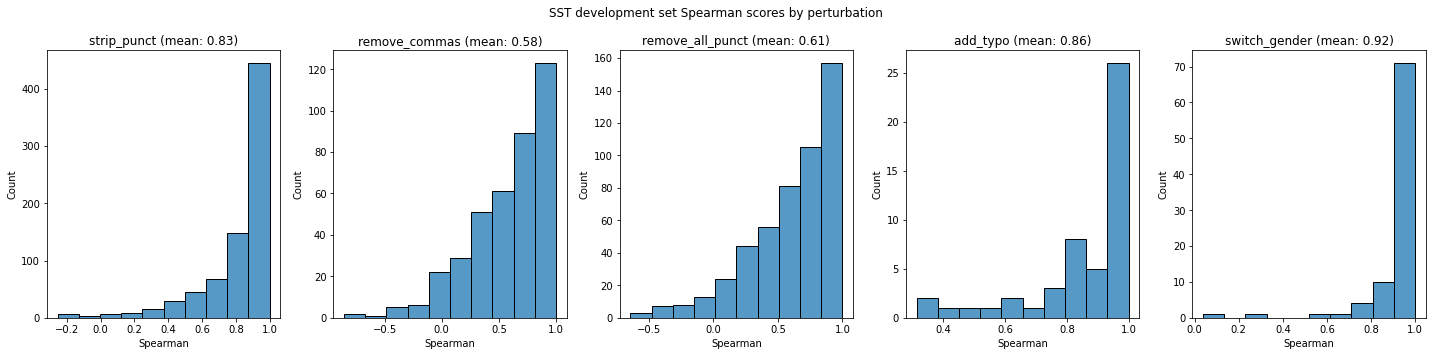

In [28]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

fig.suptitle('SST development set Spearman scores by perturbation')

i = 0
for perturbation, df in perturbation_df_dict.items():
    if df is None:
        continue
    if perturbation == 'swap_adj':
        continue
    df['spearman'] = df.apply(lambda x: spearmanr(x['shap_orig_values'], x[f'shap_{perturbation}_values']).correlation, axis=1)
    sns.histplot(df['spearman'], bins=10, ax=axes[i])
    axes[i].set_xlabel('Spearman')
    axes[i].set_title(f"{perturbation} (mean: {np.round(np.mean(df['spearman']), 2)})")
    i+=1
plt.tight_layout()
plt.savefig('reports/figures/SST BERT SHAP Spearman.png')
plt.show()

In [30]:
for perturbation, df in perturbation_df_dict.items():
    if df is None:
        continue
    if perturbation == 'swap_adj':
        continue
    df['spearman'] = df.apply(lambda x: spearmanr(x['shap_orig_values'], x[f'shap_{perturbation}_values']).correlation, axis=1)
    print(perturbation)
    print(f"Mean Spearman: {df['spearman'].mean()}")
    print(f"% < 0.8 Spearman: {(df['spearman'] < 0.8).mean()}")
    print(f"% < 0.6 Spearman: {(df['spearman'] < 0.6).mean()}")
    print('\n')

strip_punct
Mean Spearman: 0.8286041828273336
% < 0.8 Spearman: 0.29381443298969073
% < 0.6 Spearman: 0.13015463917525774


remove_commas
Mean Spearman: 0.5758513845235019
% < 0.8 Spearman: 0.6658097686375322
% < 0.6 Spearman: 0.4267352185089974


remove_all_punct
Mean Spearman: 0.6132999349841529
% < 0.8 Spearman: 0.6305220883534136
% < 0.6 Spearman: 0.39959839357429716


add_typo
Mean Spearman: 0.8564333766587187
% < 0.8 Spearman: 0.22
% < 0.6 Spearman: 0.1


switch_gender
Mean Spearman: 0.9241353998317619
% < 0.8 Spearman: 0.0898876404494382
% < 0.6 Spearman: 0.033707865168539325




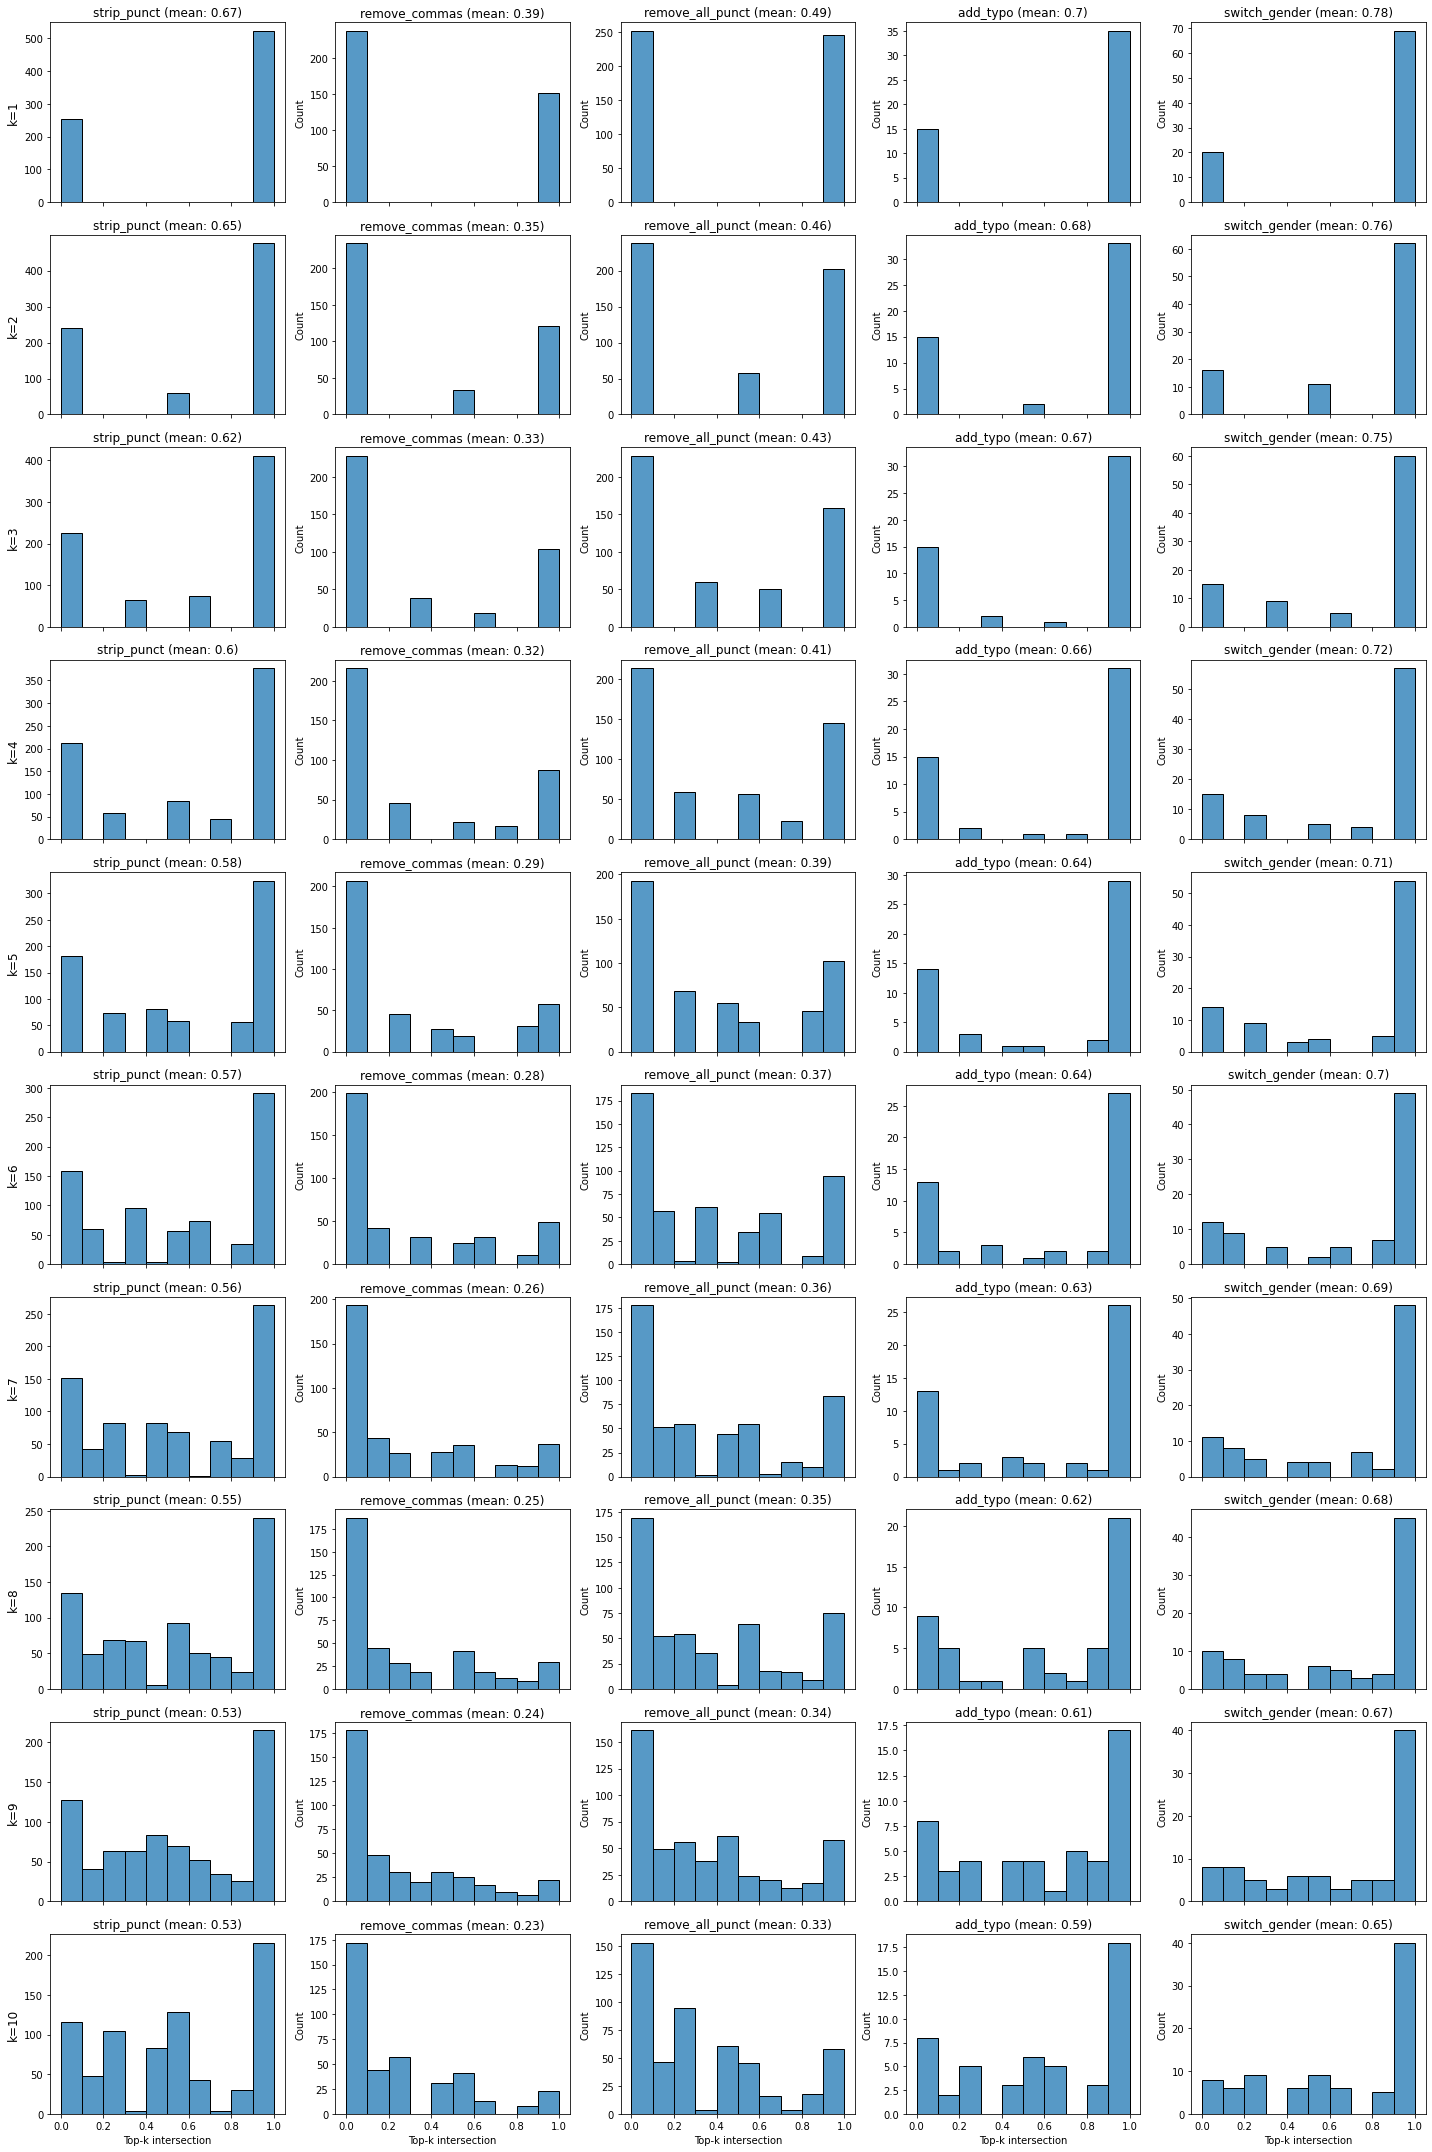

In [31]:
fig, axes = plt.subplots(10, 5, figsize=(20, 30), sharex=True)

for k in range(1, 11):
  i = 0
  for perturbation, df in perturbation_df_dict.items():
      if df is None:
          continue
      if perturbation == 'swap_adj':
          continue
      df['top_k_idx_orig'] = df.apply(lambda x: np.argsort(-np.array(x[f'shap_orig_values']))[:k], axis=1)
      df['top_k_idx_perturb'] = df.apply(lambda x: np.argsort(-x[f'shap_{perturbation}_values'])[:k], axis=1)
      
      df['k_intersection'] = df.apply(lambda x: (x['top_k_idx_orig'] == x['top_k_idx_perturb']).mean(), axis=1)

      sns.histplot(df['k_intersection'], bins=10, ax=axes[k-1, i])
      axes[k-1, i].set_xlabel('Top-k intersection')
      axes[k-1, i].set_title(f"{perturbation} (mean: {np.round(np.mean(df['k_intersection']), 2)})")
      i+=1

rows = ['k={}'.format(row) for row in range(1,11)]

# cols = ['strip_punct', 'remove_commas', 'remove_all_punct', 'add_typo', 'switch_gender']
# for ax, col in zip(axes[0], cols):
#     ax.set_title(col)

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')
    
plt.tight_layout()
plt.savefig('reports/figures/SST BERT SHAP top-k.png')
plt.show()

In [32]:
for k in range(1, 11):
  
  for perturbation, df in perturbation_df_dict.items():
      if df is None:
          continue
      if perturbation == 'swap_adj':
          continue
      df['top_k_idx_orig'] = df.apply(lambda x: np.argsort(-np.array(x[f'shap_orig_values']))[:k], axis=1)
      df['top_k_idx_perturb'] = df.apply(lambda x: np.argsort(-x[f'shap_{perturbation}_values'])[:k], axis=1)
      
      df['k_intersection'] = df.apply(lambda x: (x['top_k_idx_orig'] == x['top_k_idx_perturb']).mean(), axis=1)

      print(f"Top-{k}, {perturbation}")
      print(f"Mean: {df['k_intersection'].mean()}")
      print(f"% < 0.8: {(df['k_intersection'] < 0.8).mean()}")
      print(f"% < 0.6: {(df['k_intersection'] < 0.6).mean()}")
      print('\n')

Top-1, strip_punct
Mean: 0.6739690721649485
% < 0.8: 0.32603092783505155
% < 0.6: 0.32603092783505155


Top-1, remove_commas
Mean: 0.38817480719794345
% < 0.8: 0.6118251928020566
% < 0.6: 0.6118251928020566


Top-1, remove_all_punct
Mean: 0.4939759036144578
% < 0.8: 0.5060240963855421
% < 0.6: 0.5060240963855421


Top-1, add_typo
Mean: 0.7
% < 0.8: 0.3
% < 0.6: 0.3


Top-1, switch_gender
Mean: 0.7752808988764045
% < 0.8: 0.2247191011235955
% < 0.6: 0.2247191011235955


Top-2, strip_punct
Mean: 0.6520618556701031
% < 0.8: 0.3865979381443299
% < 0.6: 0.3865979381443299


Top-2, remove_commas
Mean: 0.35475578406169667
% < 0.8: 0.6889460154241646
% < 0.6: 0.6889460154241646


Top-2, remove_all_punct
Mean: 0.463855421686747
% < 0.8: 0.5943775100401606
% < 0.6: 0.5943775100401606


Top-2, add_typo
Mean: 0.68
% < 0.8: 0.34
% < 0.6: 0.34


Top-2, switch_gender
Mean: 0.7584269662921348
% < 0.8: 0.30337078651685395
% < 0.6: 0.30337078651685395


Top-3, strip_punct
Mean: 0.6219931271477666
% < 0.

### Visualise examples

In [29]:
import html
from IPython.core.display import display, HTML

# Prevent special characters like & and < to cause the browser to display something other than what you intended.
def html_escape(text):
    return html.escape(text)

def visualise_weights(tokens, gradients, max_alpha = 0.3):
    max_alpha = max_alpha 
    highlighted_text = []
    for i in range(len(tokens)):
        weight = gradients[i]
        highlighted_text.append('<span style="background-color:rgba(135,206,250,' + str(weight / max_alpha) + ');">' + html_escape(tokens[i]) + '</span>')
    highlighted_text = ' '.join(highlighted_text)
    print(display(HTML(highlighted_text)))

In [36]:
visualise_weights(perturbation_df_dict['remove_all_punct'].iloc[10]['shap_orig_tokens'], perturbation_df_dict['remove_all_punct'].iloc[10]['shap_orig_values'], max_alpha=0.08)

None


In [37]:
visualise_weights(perturbation_df_dict['remove_all_punct'].iloc[10]['shap_remove_all_punct_tokens'], perturbation_df_dict['remove_all_punct'].iloc[10]['shap_remove_all_punct_values'],max_alpha=0.08)

None


In [39]:
perturbation_df_dict['remove_all_punct'].head()

,sentence,label,tokens_orig,remove_all_punct_concat,remove_all_punct_tokens,remove_all_punct_success,remove_all_punct_pert_ind,orig_prediction,remove_all_punct_prediction,correct_prediction,shap_orig_tokens,shap_orig_values,shap_remove_all_punct_tokens,shap_remove_all_punct_values,most_important_indices,important_token_changed,token_length_mismatch,spearman
0,It 's a lovely film with lovely performances b...,3,"[it, ', s, a, lovely, film, with, lovely, perf...",it s a lovely film with lovely performances b...,"[it, , s, a, lovely, film, with, lovely, perfo...",1,"[1, 15]",4,4,0,"[it , s , a , lovely , film , with , lovely , ...","[0.0022263596765697002, 0.0022263596765697002,...","[it , s , a , lovely , film , with , lovely , ...","[0.029858328867703676, 0.029858328867703676, 0...","[3, 4, 5, 6, 7]",0,0,-0.116550
1,"No one goes unindicted here , which is probabl...",2,"[no, one, goes, un, ##ind, ##ic, ##ted, here, ...",no one goes unindicted here which is probably...,"[no, one, goes, un, ##ind, ##ic, ##ted, here, ...",1,"[8, 15]",2,2,1,"[no , one , goes , un , ##ind , ##ic , ##ted ,...","[0.01547006165815724, 0.01547006165815724, 0.0...","[no , one , goes , un , ##ind , ##ic , ##ted ,...","[0.015522892897327742, 0.015522892897327742, 0...","[11, 12, 2, 9, 10]",0,0,0.015099
4,Uses sharp humor and insight into human nature...,4,"[uses, sharp, humor, and, insight, into, human...",uses sharp humor and insight into human nature...,"[uses, sharp, humor, and, insight, into, human...",1,"[12, 15, 23]",3,3,0,"[uses , sharp , humor , and , insight , into ,...","[0.05117771138126651, 0.05117771138126651, 0.0...","[uses , sharp , humor , and , insight , into ,...","[0.049314494244754314, 0.049314494244754314, 0...","[0, 1, 2, 3, 4]",0,0,0.749730
6,"Entertains by providing good , lively company .",3,"[entertain, ##s, by, providing, good, ,, livel...",entertains by providing good lively company,"[entertain, ##s, by, providing, good, , lively...",1,"[5, 8]",3,3,1,"[entertain , ##s , by , providing , good , liv...","[0.05856792783985536, 0.05856792783985536, 0.0...","[entertain , ##s , by , providing , good , liv...","[0.12981989048421383, 0.05778254382312298, 0.0...","[6, 7, 0, 1, 2]",0,0,0.207695
12,The band 's courage in the face of official re...,3,"[the, band, ', s, courage, in, the, face, of, ...",the band s courage in the face of official re...,"[the, band, , s, courage, in, the, face, of, o...",1,"[2, 13, 19, 23, 24]",3,3,1,"[the , band , s , courage , in , the , face , ...","[0.01511618250515312, 0.01511618250515312, 0.0...","[the , band , s , courage , in , the , face , ...","[0.026905262377113104, 0.026905262377113104, 0...","[16, 15, 14, 18, 17]",0,0,-0.480363


In [55]:
np.argsort(-perturbation_df_dict['remove_all_punct'].iloc[0]['shap_remove_all_punct_values'])[:5]

array([11, 12,  4,  5,  6])

In [56]:
np.argsort(-np.array(perturbation_df_dict['remove_all_punct'].iloc[0]['shap_orig_values']))[:5]

array([2, 3, 4, 5, 6])

In [57]:
np.argsort(-perturbation_df_dict['remove_all_punct'].iloc[0]['shap_remove_all_punct_values'])[:5] == np.argsort(-np.array(perturbation_df_dict['remove_all_punct'].iloc[0]['shap_orig_values']))[:5]

array([False, False,  True,  True,  True])

### Save as pickle

In [35]:
pickle.dump(perturbation_df_dict, open('data/perturbation_df_dict_SST_BERT.pickle', 'wb'))

In [36]:
# loaded_model = pickle.load(open('data/perturbation_df_dict_SST_BERT.pickle', 'rb'))

## SHAP for AG News

In [40]:
dev['agnews'].head()

,sentence,label,title
108000,The IMF has said it will negotiate with Argent...,2,"Argentina can wait, says IMF"
108001,Finnish mobile giant Nokia is losing the head ...,2,Nokia loses top network executive
108002,"The Halifax bank, Britain's biggest mortgage l...",2,Halifax predicts house-price fall
108003,AFP - Eurozone retail sales rose 0.7 percent i...,2,Eurozone retail sales rise 0.7 percent in Octo...
108004,Bells will be ringing at Mervyn';s department ...,2,Mervyn #39;s reverses ban on kettles


In [42]:
shap_explainer = SHAPExplainer(bert_agnews)

In [44]:
%%time
IMPORTANT_WORD_CUTOFF = 5
"""
Top-x words considered most important based on SHAP value. If perturbation affects any of these tokens the example is not considered for evaluation
"""

MAX_NUMBER_EXAMPLES = 500


perturbation_df_dict = {}


for perturbation in PERTURBATION_LIST:
    
    print(perturbation)
    
    #===============================================#
    # Add perturbed sentences to dataframe          #
    #===============================================#
    
    perturbation_df = add_perturbations(
        df=dev['agnews'],
        tokenizer=bert_agnews.tokenizer,
        sentence_col_name=agnews.SENTENCE, 
        perturbation_functions=[
            PERT_STRING_TO_FUNCTION[perturbation]
        ]
    )
    print(1)
    print(perturbation_df.shape)
    
    #===============================================#
    # Drop unsuccessful perturbations               #
    #===============================================#
    
    perturbation_df = perturbation_df.copy()[perturbation_df[f'{perturbation}_success'] == 1]
    print(2)
    print(perturbation_df.shape)
    if perturbation_df.shape[0] <= 2:
        print(f'Skipped {perturbation}')
        print('\n')
        perturbation_df_dict[perturbation] = None
        continue
    if perturbation_df.shape[0] > MAX_NUMBER_EXAMPLES:
        np.random.seed(3)
        perturbation_df = perturbation_df.copy().sample(n=MAX_NUMBER_EXAMPLES)
        print(f'Filtered examples for {perturbation}')

    #====================================================================#
    # Overwrite '_concat' column with corrected reversal of tokenization #
    #====================================================================#
    
    perturbation_df[f'{perturbation}_concat'] = perturbation_df[f'{perturbation}_tokens'].apply(bert_detokenize)
    
    #===============================================#
    # Original prediction                           #
    #===============================================#
    
    perturbation_df['orig_prediction'] = bert_agnews.predict_label_batch(perturbation_df['sentence'])
    
    #===============================================#
    # Prediction on new sentence                    #
    #===============================================#
    
    perturbation_df[f'{perturbation}_prediction'] = bert_agnews.predict_label_batch(perturbation_df[f'{perturbation}_concat'])
    
    #========================================================#
    # Drop examples where predictions which are not the same #
    #========================================================#
    
    perturbation_df = perturbation_df.copy()[perturbation_df[f'{perturbation}_prediction'] == perturbation_df['orig_prediction']]
    print(3)
    print(perturbation_df.shape)
    if perturbation_df.shape[0] <= 2:
        print(f'Skipped {perturbation}')
        print('\n')
        perturbation_df_dict[perturbation] = None
        continue
    
    #===============================================#
    # Flag for correct prediction                   #
    #===============================================#

    perturbation_df['correct_prediction'] = np.where(
        perturbation_df['label'] == perturbation_df['orig_prediction'],
        1,
        0
    )
    print(4)
    print(perturbation_df['correct_prediction'].sum())
    
    #===============================================#
    # SHAP values for original sentence             #
    #===============================================#
    
    shap_values = shap_explainer.explain_instances(perturbation_df['sentence'])
    
    perturbation_df['shap_orig_tokens'] = shap_values.data
    perturbation_df['shap_orig_tokens'] = perturbation_df['shap_orig_tokens'].apply(lambda x: x[1:-1])  # Drop first and last as these correspond to special tokens
    
    perturbation_df['shap_orig_values'] = shap_values.values
    perturbation_df['shap_orig_values'] = perturbation_df['shap_orig_values'].apply(lambda x: x[1:-1, :])  # Drop first and last as these correspond to special tokens

    # Only keep SHAP values for label predicted
    perturbation_df['shap_orig_values'] = perturbation_df.apply(lambda x: x['shap_orig_values'][:, x['orig_prediction']], axis=1)
    
    # Length of SHAP tokens same as length of SHAP values
    assert perturbation_df.shape[0] == (perturbation_df['shap_orig_tokens'].apply(len) == perturbation_df['shap_orig_values'].apply(len)).sum()
    
    #===============================================#
    # SHAP values for perturbed sentence            #
    #===============================================#
    
    shap_values = shap_explainer.explain_instances(perturbation_df[f'{perturbation}_concat'])

    perturbation_df[f'shap_{perturbation}_tokens'] = shap_values.data
    perturbation_df[f'shap_{perturbation}_tokens'] = perturbation_df[f'shap_{perturbation}_tokens'].apply(lambda x: x[1:-1])  # Drop first and last as these correspond to special tokens

    perturbation_df[f'shap_{perturbation}_values'] = shap_values.values
    perturbation_df[f'shap_{perturbation}_values'] = perturbation_df[f'shap_{perturbation}_values'].apply(lambda x: x[1:-1, :])  # Drop first and last as these correspond to special tokens

    # Only keep SHAP values for label predicted
    perturbation_df[f'shap_{perturbation}_values'] = perturbation_df.apply(lambda x: x[f'shap_{perturbation}_values'][:, x['orig_prediction']], axis=1)

    # Length of SHAP tokens same as length of SHAP values
    assert perturbation_df.shape[0] == (perturbation_df[f'shap_{perturbation}_tokens'].apply(len) == perturbation_df[f'shap_{perturbation}_values'].apply(len)).sum()

    #====================================================#
    # Drop examples where an important token was changed #
    #====================================================#

    perturbation_df['most_important_indices'] = perturbation_df['shap_orig_values'].apply(lambda x: np.argsort(-x)[:5])  # -as sorts in ascending order otherwise

    perturbation_df['important_token_changed'] = perturbation_df.apply(
        lambda x: any(
            idx in x['most_important_indices'] for idx in x[f'{perturbation}_pert_ind']
        ), 
        axis=1
    )

    perturbation_df['important_token_changed'] = perturbation_df['important_token_changed'].astype(int)

    perturbation_df = perturbation_df.copy()[perturbation_df['important_token_changed'] == 0]
    
    print(5)
    print(perturbation_df.shape)

    #===============================================================#
    # Additional criteria if perturbation in PERTURBATION_REDUCTION #
    #===============================================================#
    
    if perturbation in PERTURBATION_REDUCTION:

        perturbation_df['shap_orig_tokens'] = perturbation_df.apply(
            lambda x: [
                token for i, token in enumerate(x['shap_orig_tokens']) if i not in x[f'{perturbation}_pert_ind']
            ], 
            axis=1
        )

        perturbation_df['shap_orig_values'] = perturbation_df.apply(
            lambda x: [
                token for i, token in enumerate(x['shap_orig_values']) if i not in x[f'{perturbation}_pert_ind']
            ], 
            axis=1
        )

    # Check number of tokens in original matches number in perturbed
    perturbation_df['token_length_mismatch'] = np.where(
        perturbation_df['shap_orig_tokens'].apply(len) != perturbation_df[f'shap_{perturbation}_tokens'].apply(len),
        1,
        0
    )
    perturbation_df = perturbation_df.copy()[perturbation_df['token_length_mismatch'] == 0]
    print(6)
    print(perturbation_df.shape)
    if perturbation_df.shape[0] <= 2:
        print(f'Skipped {perturbation}')
        print('\n')
        perturbation_df_dict[perturbation] = None
        continue
    
    assert (perturbation_df['shap_orig_tokens'].apply(len) == perturbation_df[f'shap_{perturbation}_tokens'].apply(len)).mean() == 1
    
    # Store dataframe
    perturbation_df_dict[perturbation] = perturbation_df
    
    print('\n')

strip_punct
1
(12000, 8)
2
(10523, 8)
Filtered examples for strip_punct
3
(498, 10)
4
469


Partition explainer: 499it [06:10,  1.31it/s]
Partition explainer: 499it [06:10,  1.31it/s]


5
(416, 17)
6
(416, 18)


remove_commas
1
(12000, 8)
2
(8253, 8)
Filtered examples for remove_commas
3
(496, 10)
4
455


Partition explainer: 497it [06:10,  1.30it/s]
Partition explainer: 497it [06:09,  1.31it/s]


5
(390, 17)
6
(390, 18)


remove_all_punct
1
(12000, 8)
2
(11956, 8)
Filtered examples for remove_all_punct
3
(490, 10)
4
467


Partition explainer: 491it [06:05,  1.31it/s]
Partition explainer: 491it [06:03,  1.31it/s]


5
(217, 17)
6
(217, 18)


contraction
1
(12000, 8)
2
(1046, 8)
Filtered examples for contraction
3
(497, 10)
4
463


Partition explainer: 498it [06:12,  1.30it/s]
Partition explainer: 498it [06:12,  1.30it/s]


5
(447, 17)
6
(0, 18)
Skipped contraction


change_first_name
1
(12000, 8)
2
(1, 8)
Skipped change_first_name


change_last_name
1
(12000, 8)
2
(7, 8)
3
(7, 10)
4
7
5
(4, 17)
6
(4, 18)


change_location
1
(12000, 8)
2
(0, 8)
Skipped change_location


add_typo
1
(12000, 8)
2
(12000, 8)
Filtered examples for add_typo
3
(487, 10)
4
451


Partition explainer: 488it [06:02,  1.31it/s]
Partition explainer: 488it [06:03,  1.30it/s]


5
(405, 17)
6
(26, 18)


switch_gender
1
(12000, 8)
2
(2179, 8)
Filtered examples for switch_gender
3
(497, 10)
4
481


Partition explainer: 498it [06:11,  1.30it/s]
Partition explainer: 498it [06:11,  1.30it/s]


5
(440, 17)
6
(439, 18)


CPU times: user 53min 27s, sys: 25min 39s, total: 1h 19min 6s
Wall time: 1h 18min 50s


### Visualisation

In [45]:
non_none = 0
for df in perturbation_df_dict.values():
  if df is not None:
    non_none += 1
non_none

6

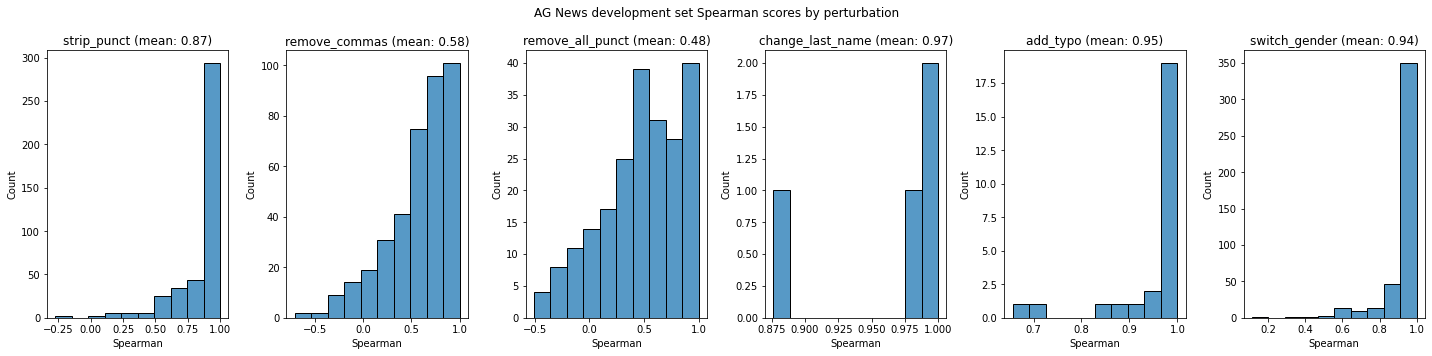

In [46]:
fig, axes = plt.subplots(1, 6, figsize=(20, 5))

fig.suptitle('AG News development set Spearman scores by perturbation')

i = 0
for perturbation, df in perturbation_df_dict.items():
    if df is None:
        continue
    if perturbation == 'swap_adj':
        continue
    df['spearman'] = df.apply(lambda x: spearmanr(x['shap_orig_values'], x[f'shap_{perturbation}_values']).correlation, axis=1)
    sns.histplot(df['spearman'], bins=10, ax=axes[i])
    axes[i].set_xlabel('Spearman')
    axes[i].set_title(f"{perturbation} (mean: {np.round(np.mean(df['spearman']), 2)})")
    i+=1
plt.tight_layout()
plt.savefig('reports/figures/AG News BERT SHAP Spearman.png')
plt.show()

In [47]:
for perturbation, df in perturbation_df_dict.items():
    if df is None:
        continue
    if perturbation == 'swap_adj':
        continue
    df['spearman'] = df.apply(lambda x: spearmanr(x['shap_orig_values'], x[f'shap_{perturbation}_values']).correlation, axis=1)
    print(perturbation)
    print(f"Mean Spearman: {df['spearman'].mean()}")
    print(f"% < 0.8 Spearman: {(df['spearman'] < 0.8).mean()}")
    print(f"% < 0.6 Spearman: {(df['spearman'] < 0.6).mean()}")
    print('\n')

strip_punct
Mean Spearman: 0.8712574521611107
% < 0.8 Spearman: 0.21875
% < 0.6 Spearman: 0.0889423076923077


remove_commas
Mean Spearman: 0.5821682501127845
% < 0.8 Spearman: 0.7205128205128205
% < 0.6 Spearman: 0.41794871794871796


remove_all_punct
Mean Spearman: 0.4775999787911378
% < 0.8 Spearman: 0.7741935483870968
% < 0.6 Spearman: 0.5944700460829493


change_last_name
Mean Spearman: 0.9651087835849701
% < 0.8 Spearman: 0.0
% < 0.6 Spearman: 0.0


add_typo
Mean Spearman: 0.9507416381969758
% < 0.8 Spearman: 0.07692307692307693
% < 0.6 Spearman: 0.0


switch_gender
Mean Spearman: 0.9408973121080959
% < 0.8 Spearman: 0.0888382687927107
% < 0.6 Spearman: 0.029612756264236904




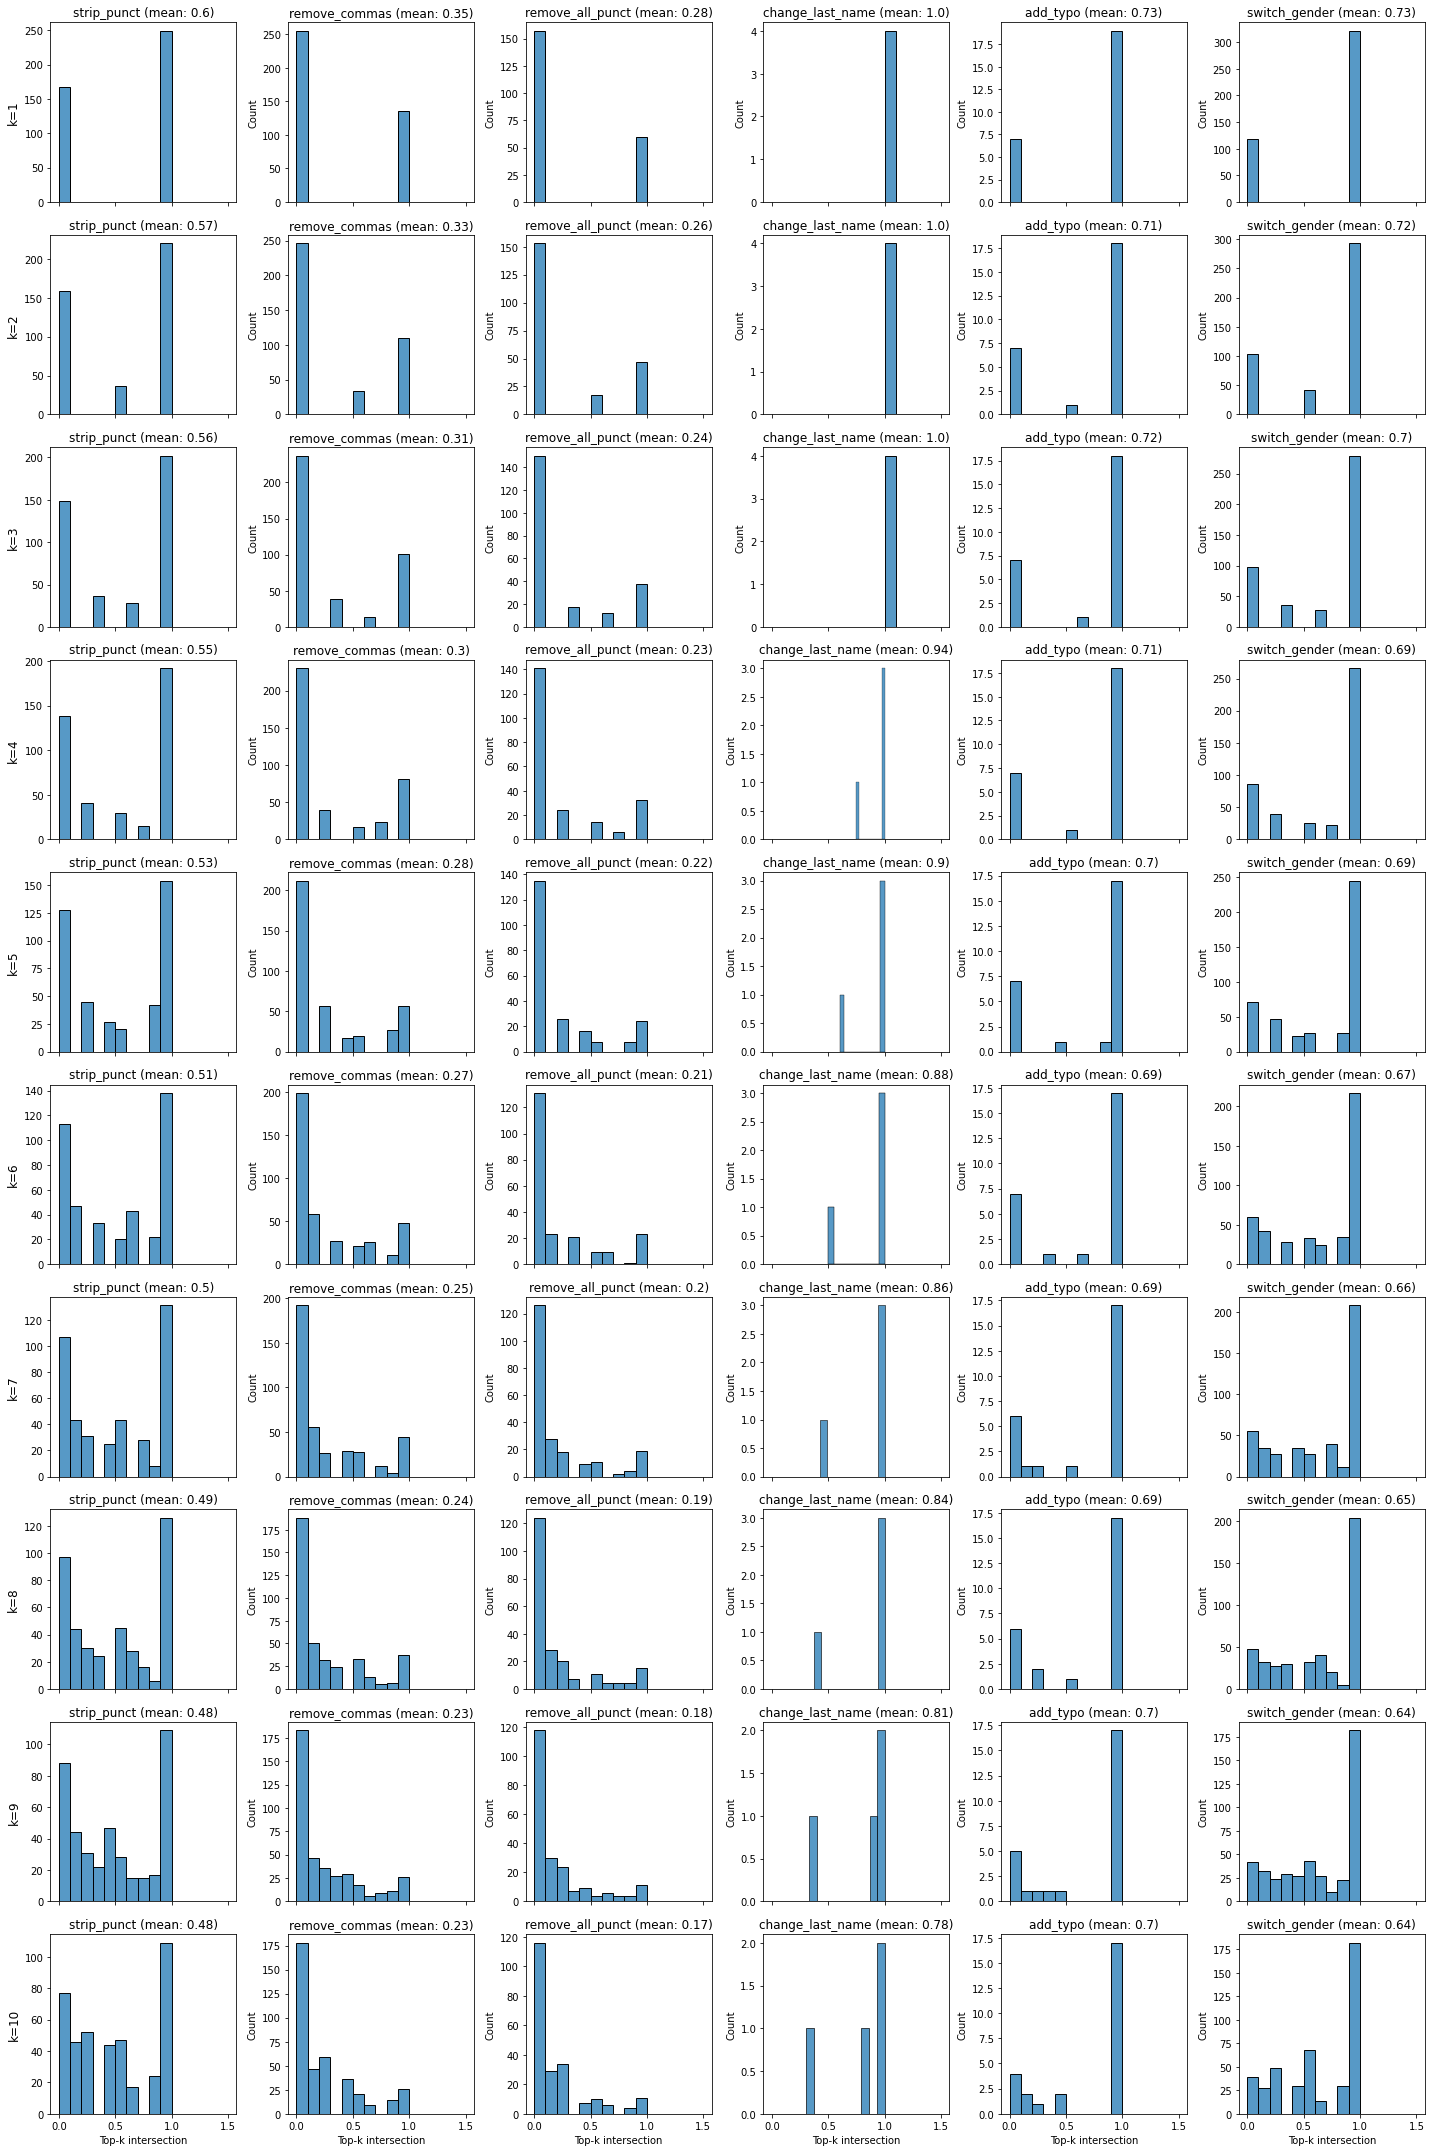

In [48]:
fig, axes = plt.subplots(10, 6, figsize=(20, 30), sharex=True)

for k in range(1, 11):
  i = 0
  for perturbation, df in perturbation_df_dict.items():
      if df is None:
          continue
      if perturbation == 'swap_adj':
          continue
      df['top_k_idx_orig'] = df.apply(lambda x: np.argsort(-np.array(x[f'shap_orig_values']))[:k], axis=1)
      df['top_k_idx_perturb'] = df.apply(lambda x: np.argsort(-x[f'shap_{perturbation}_values'])[:k], axis=1)
      
      df['k_intersection'] = df.apply(lambda x: (x['top_k_idx_orig'] == x['top_k_idx_perturb']).mean(), axis=1)

      sns.histplot(df['k_intersection'], bins=10, ax=axes[k-1, i])
      axes[k-1, i].set_xlabel('Top-k intersection')
      axes[k-1, i].set_title(f"{perturbation} (mean: {np.round(np.mean(df['k_intersection']), 2)})")
      i+=1

rows = ['k={}'.format(row) for row in range(1,11)]

# cols = ['strip_punct', 'remove_commas', 'remove_all_punct', 'add_typo', 'switch_gender']
# for ax, col in zip(axes[0], cols):
#     ax.set_title(col)

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')
    
plt.tight_layout()
plt.savefig('reports/figures/AG News BERT SHAP top-k.png')
plt.show()

In [49]:
for k in range(1, 11):
  
  for perturbation, df in perturbation_df_dict.items():
      if df is None:
          continue
      if perturbation == 'swap_adj':
          continue
      df['top_k_idx_orig'] = df.apply(lambda x: np.argsort(-np.array(x[f'shap_orig_values']))[:k], axis=1)
      df['top_k_idx_perturb'] = df.apply(lambda x: np.argsort(-x[f'shap_{perturbation}_values'])[:k], axis=1)
      
      df['k_intersection'] = df.apply(lambda x: (x['top_k_idx_orig'] == x['top_k_idx_perturb']).mean(), axis=1)

      print(f"Top-{k}, {perturbation}")
      print(f"Mean: {df['k_intersection'].mean()}")
      print(f"% < 0.8: {(df['k_intersection'] < 0.8).mean()}")
      print(f"% < 0.6: {(df['k_intersection'] < 0.6).mean()}")
      print('\n')

Top-1, strip_punct
Mean: 0.5985576923076923
% < 0.8: 0.4014423076923077
% < 0.6: 0.4014423076923077


Top-1, remove_commas
Mean: 0.34615384615384615
% < 0.8: 0.6538461538461539
% < 0.6: 0.6538461538461539


Top-1, remove_all_punct
Mean: 0.2764976958525346
% < 0.8: 0.7235023041474654
% < 0.6: 0.7235023041474654


Top-1, change_last_name
Mean: 1.0
% < 0.8: 0.0
% < 0.6: 0.0


Top-1, add_typo
Mean: 0.7307692307692307
% < 0.8: 0.2692307692307692
% < 0.6: 0.2692307692307692


Top-1, switch_gender
Mean: 0.7312072892938497
% < 0.8: 0.26879271070615035
% < 0.6: 0.26879271070615035


Top-2, strip_punct
Mean: 0.5733173076923077
% < 0.8: 0.47115384615384615
% < 0.6: 0.47115384615384615


Top-2, remove_commas
Mean: 0.32564102564102565
% < 0.8: 0.717948717948718
% < 0.6: 0.717948717948718


Top-2, remove_all_punct
Mean: 0.2557603686635945
% < 0.8: 0.783410138248848
% < 0.6: 0.783410138248848


Top-2, change_last_name
Mean: 1.0
% < 0.8: 0.0
% < 0.6: 0.0


Top-2, add_typo
Mean: 0.7115384615384616
% < 

In [50]:
pickle.dump(perturbation_df_dict, open('data/perturbation_df_dict_AGNews_BERT.pickle', 'wb'))

In [ ]:
# loaded_model = pickle.load(open('data/perturbation_df_dict_AGNews_BERT.pickle', 'rb'))

### TODOs

- Logic for `swap_adj`
- Incorporate full SHAP return object for easy example visualisation
- Spot check examples for each perturbation to check that everything working as intended